##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to classify images of flowers. It creates an image classifier using a `keras.Sequential` model, and loads data using `preprocessing.image_dataset_from_directory`. You will gain practical experience with the following concepts:

* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and Dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

In [2]:
!pip install -q tf-nightly

## Import TensorFlow and other libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains 5 sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [4]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

     8192/228813984 [..............................] - ETA: 4s

  5414912/228813984 [..............................] - ETA: 2s

 11083776/228813984 [>.............................] - ETA: 1s

 16760832/228813984 [=>............................] - ETA: 1s

 22446080/228813984 [=>............................] - ETA: 1s

 25174016/228813984 [==>...........................] - ETA: 7s

 36454400/228813984 [===>..........................] - ETA: 5s

 48439296/228813984 [=====>........................] - ETA: 3s

 60489728/228813984 [======>.......................] - ETA: 2s

 72433664/228813984 [========>.....................] - ETA: 2s

 83001344/228813984 [=========>....................] - ETA: 2s

 92856320/228813984 [===========>..................] - ETA: 1s

104849408/228813984 [============>.................] - ETA: 1s

117137408/228813984 [==============>...............] - ETA: 1s

129343488/228813984 [===============>..............] - ETA: 1s

134225920/228813984 [================>.............] - ETA: 2s

143007744/228813984 [=================>............] - ETA: 1s

155828224/228813984 [===================>..........] - ETA: 1s

168378368/228813984 [=====================>........] - ETA: 1s

176168960/228813984 [======================>.......] - ETA: 1s

187670528/228813984 [=======================>......] - ETA: 0s

192946176/228813984 [========================>.....] - ETA: 0s

206045184/228813984 [==========================>...] - ETA: 0s

220078080/228813984 [===========================>..] - ETA: 0s

228818944/228813984 [==============================] - 4s 0us/step


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

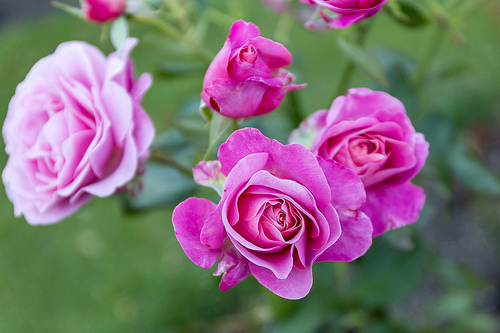

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

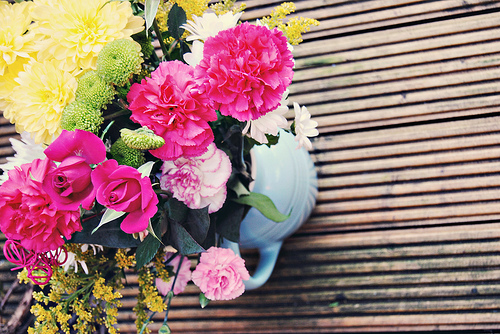

In [7]:
PIL.Image.open(str(roses[1]))

And some tulips:

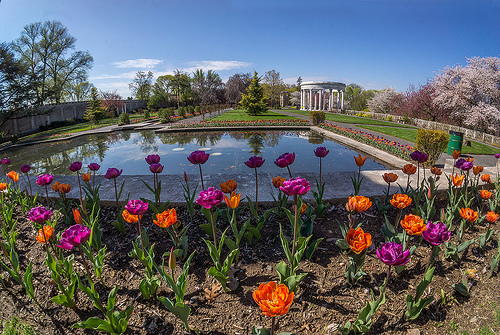

In [8]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

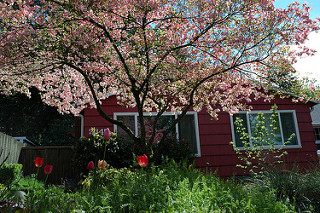

In [9]:
PIL.Image.open(str(tulips[1]))

# Load using keras.preprocessing

Let's load these images off disk using the helpful [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.

## Create a dataset

Define some parameters for the loader:

In [10]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. We will use 80% of the images for training, and 20% for validation.

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [13]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first 9 images from the training dataset.

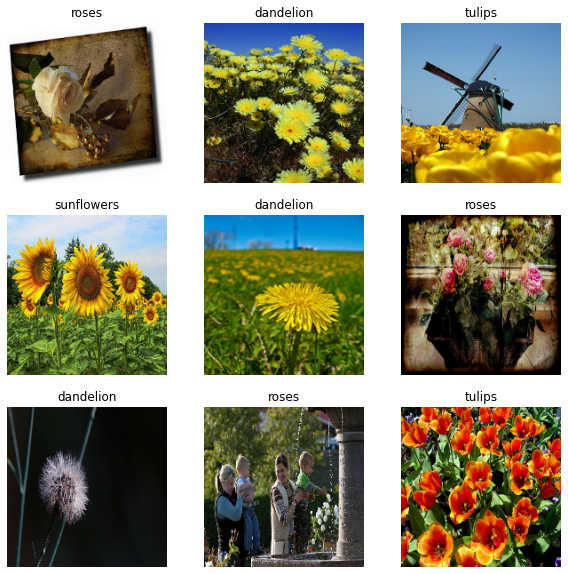

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to `model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension referes to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. 

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the `[0, 1]` by using a Rescaling layer.

In [17]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Note: The Keras Preprocesing utilities and layers introduced in this section are currently experimental and may change.

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. We will use the second approach here.

Note: we previously resized images using the `image_size` argument of `image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer.

# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach. 

In [19]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

For this tutorial, choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `summary` method:

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Train the model

In [22]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


 1/92 [..............................] - ETA: 2:57 - loss: 1.6159 - accuracy: 0.1875

 7/92 [=>............................] - ETA: 24s - loss: 3.5051 - accuracy: 0.1989 

13/92 [===>..........................] - ETA: 12s - loss: 3.0857 - accuracy: 0.2018

19/92 [=====>........................] - ETA: 8s - loss: 2.8144 - accuracy: 0.1995 

25/92 [=======>......................] - ETA: 5s - loss: 2.6321 - accuracy: 0.2011

30/92 [========>.....................] - ETA: 4s - loss: 2.5197 - accuracy: 0.2072

36/92 [==========>...................] - ETA: 3s - loss: 2.4144 - accuracy: 0.2141

42/92 [============>.................] - ETA: 2s - loss: 2.3294 - accuracy: 0.2223

48/92 [==============>...............] - ETA: 2s - loss: 2.2586 - accuracy: 0.2306

54/92 [================>.............] - ETA: 1s - loss: 2.1977 - accuracy: 0.2389

60/92 [==================>...........] - ETA: 1s - loss: 2.1448 - accuracy: 0.2467

66/92 [====================>.........] - ETA: 1s - loss: 2.0976 - accuracy: 0.2546

72/92 [======================>.......] - ETA: 0s - loss: 2.0548 - accuracy: 0.2629

78/92 [========================>.....] - ETA: 0s - loss: 2.0158 - accuracy: 0.2707

84/92 [==========================>...] - ETA: 0s - loss: 1.9803 - accuracy: 0.2785

90/92 [============================>.] - ETA: 0s - loss: 1.9480 - accuracy: 0.2860

92/92 [==============================] - 4s 47ms/step - loss: 1.9328 - accuracy: 0.2896 - val_loss: 1.1022 - val_accuracy: 0.5245


Epoch 2/10
 1/92 [..............................] - ETA: 0s - loss: 0.9308 - accuracy: 0.5625

 8/92 [=>............................] - ETA: 0s - loss: 0.9960 - accuracy: 0.5586

15/92 [===>..........................] - ETA: 0s - loss: 1.0127 - accuracy: 0.5560

21/92 [=====>........................] - ETA: 0s - loss: 1.0314 - accuracy: 0.5520

27/92 [=======>......................] - ETA: 0s - loss: 1.0410 - accuracy: 0.5545

33/92 [=========>....................] - ETA: 0s - loss: 1.0451 - accuracy: 0.5578

39/92 [===========>..................] - ETA: 0s - loss: 1.0470 - accuracy: 0.5603

45/92 [=============>................] - ETA: 0s - loss: 1.0487 - accuracy: 0.5624

51/92 [===============>..............] - ETA: 0s - loss: 1.0498 - accuracy: 0.5644

58/92 [=================>............] - ETA: 0s - loss: 1.0496 - accuracy: 0.5669

65/92 [====================>.........] - ETA: 0s - loss: 1.0491 - accuracy: 0.5689

72/92 [======================>.......] - ETA: 0s - loss: 1.0486 - accuracy: 0.5707

78/92 [========================>.....] - ETA: 0s - loss: 1.0477 - accuracy: 0.5722

84/92 [==========================>...] - ETA: 0s - loss: 1.0463 - accuracy: 0.5739

90/92 [============================>.] - ETA: 0s - loss: 1.0449 - accuracy: 0.5754

92/92 [==============================] - 1s 10ms/step - loss: 1.0441 - accuracy: 0.5761 - val_loss: 1.0057 - val_accuracy: 0.5913


Epoch 3/10
 1/92 [..............................] - ETA: 0s - loss: 1.2275 - accuracy: 0.5625

 7/92 [=>............................] - ETA: 0s - loss: 0.9988 - accuracy: 0.6397

14/92 [===>..........................] - ETA: 0s - loss: 0.9272 - accuracy: 0.6593

21/92 [=====>........................] - ETA: 0s - loss: 0.9010 - accuracy: 0.6661

28/92 [========>.....................] - ETA: 0s - loss: 0.8924 - accuracy: 0.6675

34/92 [==========>...................] - ETA: 0s - loss: 0.8886 - accuracy: 0.6686

40/92 [============>.................] - ETA: 0s - loss: 0.8845 - accuracy: 0.6704

46/92 [==============>...............] - ETA: 0s - loss: 0.8814 - accuracy: 0.6714

52/92 [===============>..............] - ETA: 0s - loss: 0.8783 - accuracy: 0.6723

58/92 [=================>............] - ETA: 0s - loss: 0.8756 - accuracy: 0.6730

64/92 [===================>..........] - ETA: 0s - loss: 0.8731 - accuracy: 0.6736

71/92 [======================>.......] - ETA: 0s - loss: 0.8700 - accuracy: 0.6745

77/92 [========================>.....] - ETA: 0s - loss: 0.8678 - accuracy: 0.6752

83/92 [==========================>...] - ETA: 0s - loss: 0.8659 - accuracy: 0.6758

89/92 [============================>.] - ETA: 0s - loss: 0.8647 - accuracy: 0.6761

92/92 [==============================] - 1s 10ms/step - loss: 0.8640 - accuracy: 0.6763 - val_loss: 0.8951 - val_accuracy: 0.6499


Epoch 4/10
 1/92 [..............................] - ETA: 0s - loss: 0.5790 - accuracy: 0.9062

 7/92 [=>............................] - ETA: 0s - loss: 0.6671 - accuracy: 0.7899

13/92 [===>..........................] - ETA: 0s - loss: 0.6914 - accuracy: 0.7736

19/92 [=====>........................] - ETA: 0s - loss: 0.6984 - accuracy: 0.7657

25/92 [=======>......................] - ETA: 0s - loss: 0.7038 - accuracy: 0.7601

31/92 [=========>....................] - ETA: 0s - loss: 0.7104 - accuracy: 0.7545

37/92 [===========>..................] - ETA: 0s - loss: 0.7126 - accuracy: 0.7520

44/92 [=============>................] - ETA: 0s - loss: 0.7117 - accuracy: 0.7510

50/92 [===============>..............] - ETA: 0s - loss: 0.7114 - accuracy: 0.7507

56/92 [=================>............] - ETA: 0s - loss: 0.7114 - accuracy: 0.7499

62/92 [===================>..........] - ETA: 0s - loss: 0.7114 - accuracy: 0.7491

68/92 [=====================>........] - ETA: 0s - loss: 0.7115 - accuracy: 0.7485

75/92 [=======================>......] - ETA: 0s - loss: 0.7115 - accuracy: 0.7478

81/92 [=========================>....] - ETA: 0s - loss: 0.7112 - accuracy: 0.7475

88/92 [===========================>..] - ETA: 0s - loss: 0.7109 - accuracy: 0.7473

92/92 [==============================] - 1s 10ms/step - loss: 0.7106 - accuracy: 0.7472 - val_loss: 0.8992 - val_accuracy: 0.6621


Epoch 5/10
 1/92 [..............................] - ETA: 0s - loss: 0.6757 - accuracy: 0.6875

 7/92 [=>............................] - ETA: 0s - loss: 0.5212 - accuracy: 0.8048

13/92 [===>..........................] - ETA: 0s - loss: 0.4976 - accuracy: 0.8203

19/92 [=====>........................] - ETA: 0s - loss: 0.4887 - accuracy: 0.8241

25/92 [=======>......................] - ETA: 0s - loss: 0.4827 - accuracy: 0.8273

31/92 [=========>....................] - ETA: 0s - loss: 0.4796 - accuracy: 0.8290

37/92 [===========>..................] - ETA: 0s - loss: 0.4787 - accuracy: 0.8299

44/92 [=============>................] - ETA: 0s - loss: 0.4787 - accuracy: 0.8307

50/92 [===============>..............] - ETA: 0s - loss: 0.4787 - accuracy: 0.8311

56/92 [=================>............] - ETA: 0s - loss: 0.4784 - accuracy: 0.8314

62/92 [===================>..........] - ETA: 0s - loss: 0.4784 - accuracy: 0.8313

69/92 [=====================>........] - ETA: 0s - loss: 0.4785 - accuracy: 0.8312

75/92 [=======================>......] - ETA: 0s - loss: 0.4790 - accuracy: 0.8307

81/92 [=========================>....] - ETA: 0s - loss: 0.4798 - accuracy: 0.8300

87/92 [===========================>..] - ETA: 0s - loss: 0.4808 - accuracy: 0.8292

92/92 [==============================] - 1s 10ms/step - loss: 0.4817 - accuracy: 0.8285 - val_loss: 0.8997 - val_accuracy: 0.6662


Epoch 6/10


 1/92 [..............................] - ETA: 0s - loss: 0.2128 - accuracy: 0.9375

 7/92 [=>............................] - ETA: 0s - loss: 0.3220 - accuracy: 0.8886

14/92 [===>..........................] - ETA: 0s - loss: 0.3353 - accuracy: 0.8823

20/92 [=====>........................] - ETA: 0s - loss: 0.3339 - accuracy: 0.8830

26/92 [=======>......................] - ETA: 0s - loss: 0.3297 - accuracy: 0.8853

33/92 [=========>....................] - ETA: 0s - loss: 0.3238 - accuracy: 0.8875

39/92 [===========>..................] - ETA: 0s - loss: 0.3205 - accuracy: 0.8887

46/92 [==============>...............] - ETA: 0s - loss: 0.3183 - accuracy: 0.8896

53/92 [================>.............] - ETA: 0s - loss: 0.3168 - accuracy: 0.8899

59/92 [==================>...........] - ETA: 0s - loss: 0.3159 - accuracy: 0.8901

65/92 [====================>.........] - ETA: 0s - loss: 0.3148 - accuracy: 0.8904

72/92 [======================>.......] - ETA: 0s - loss: 0.3139 - accuracy: 0.8906

78/92 [========================>.....] - ETA: 0s - loss: 0.3135 - accuracy: 0.8905

84/92 [==========================>...] - ETA: 0s - loss: 0.3134 - accuracy: 0.8904

91/92 [============================>.] - ETA: 0s - loss: 0.3131 - accuracy: 0.8904

92/92 [==============================] - 1s 10ms/step - loss: 0.3131 - accuracy: 0.8903 - val_loss: 1.0014 - val_accuracy: 0.6567


Epoch 7/10
 1/92 [..............................] - ETA: 0s - loss: 0.1995 - accuracy: 0.9375

 7/92 [=>............................] - ETA: 0s - loss: 0.1914 - accuracy: 0.9306

13/92 [===>..........................] - ETA: 0s - loss: 0.1951 - accuracy: 0.9326

19/92 [=====>........................] - ETA: 0s - loss: 0.1927 - accuracy: 0.9366

25/92 [=======>......................] - ETA: 0s - loss: 0.1898 - accuracy: 0.9388

31/92 [=========>....................] - ETA: 0s - loss: 0.1875 - accuracy: 0.9404

37/92 [===========>..................] - ETA: 0s - loss: 0.1848 - accuracy: 0.9417

43/92 [=============>................] - ETA: 0s - loss: 0.1827 - accuracy: 0.9426

49/92 [==============>...............] - ETA: 0s - loss: 0.1809 - accuracy: 0.9432

55/92 [================>.............] - ETA: 0s - loss: 0.1795 - accuracy: 0.9436

61/92 [==================>...........] - ETA: 0s - loss: 0.1785 - accuracy: 0.9437

67/92 [====================>.........] - ETA: 0s - loss: 0.1778 - accuracy: 0.9438

73/92 [======================>.......] - ETA: 0s - loss: 0.1779 - accuracy: 0.9437

79/92 [========================>.....] - ETA: 0s - loss: 0.1781 - accuracy: 0.9436

86/92 [===========================>..] - ETA: 0s - loss: 0.1782 - accuracy: 0.9435

92/92 [==============================] - ETA: 0s - loss: 0.1782 - accuracy: 0.9436

92/92 [==============================] - 1s 10ms/step - loss: 0.1782 - accuracy: 0.9436 - val_loss: 1.2140 - val_accuracy: 0.6431


Epoch 8/10
 1/92 [..............................] - ETA: 0s - loss: 0.1120 - accuracy: 0.9688

 8/92 [=>............................] - ETA: 0s - loss: 0.0907 - accuracy: 0.9804

14/92 [===>..........................] - ETA: 0s - loss: 0.0960 - accuracy: 0.9760

21/92 [=====>........................] - ETA: 0s - loss: 0.1006 - accuracy: 0.9726

27/92 [=======>......................] - ETA: 0s - loss: 0.1007 - accuracy: 0.9719

33/92 [=========>....................] - ETA: 0s - loss: 0.1001 - accuracy: 0.9717

40/92 [============>.................] - ETA: 0s - loss: 0.0999 - accuracy: 0.9716

47/92 [==============>...............] - ETA: 0s - loss: 0.1000 - accuracy: 0.9715

53/92 [================>.............] - ETA: 0s - loss: 0.1004 - accuracy: 0.9715

59/92 [==================>...........] - ETA: 0s - loss: 0.1006 - accuracy: 0.9715

66/92 [====================>.........] - ETA: 0s - loss: 0.1006 - accuracy: 0.9714

72/92 [======================>.......] - ETA: 0s - loss: 0.1009 - accuracy: 0.9711

78/92 [========================>.....] - ETA: 0s - loss: 0.1011 - accuracy: 0.9709

85/92 [==========================>...] - ETA: 0s - loss: 0.1017 - accuracy: 0.9706

91/92 [============================>.] - ETA: 0s - loss: 0.1022 - accuracy: 0.9703

92/92 [==============================] - 1s 10ms/step - loss: 0.1024 - accuracy: 0.9703 - val_loss: 1.5144 - val_accuracy: 0.6240


Epoch 9/10
 1/92 [..............................] - ETA: 0s - loss: 0.0813 - accuracy: 1.0000

 7/92 [=>............................] - ETA: 0s - loss: 0.0758 - accuracy: 0.9802

13/92 [===>..........................] - ETA: 0s - loss: 0.0785 - accuracy: 0.9772

20/92 [=====>........................] - ETA: 0s - loss: 0.0752 - accuracy: 0.9792

26/92 [=======>......................] - ETA: 0s - loss: 0.0724 - accuracy: 0.9809

32/92 [=========>....................] - ETA: 0s - loss: 0.0707 - accuracy: 0.9820

38/92 [===========>..................] - ETA: 0s - loss: 0.0692 - accuracy: 0.9828

44/92 [=============>................] - ETA: 0s - loss: 0.0689 - accuracy: 0.9830

50/92 [===============>..............] - ETA: 0s - loss: 0.0688 - accuracy: 0.9831

57/92 [=================>............] - ETA: 0s - loss: 0.0691 - accuracy: 0.9830

63/92 [===================>..........] - ETA: 0s - loss: 0.0695 - accuracy: 0.9829

69/92 [=====================>........] - ETA: 0s - loss: 0.0702 - accuracy: 0.9828

75/92 [=======================>......] - ETA: 0s - loss: 0.0710 - accuracy: 0.9825

82/92 [=========================>....] - ETA: 0s - loss: 0.0721 - accuracy: 0.9821

88/92 [===========================>..] - ETA: 0s - loss: 0.0729 - accuracy: 0.9818

92/92 [==============================] - 1s 10ms/step - loss: 0.0736 - accuracy: 0.9815 - val_loss: 1.7651 - val_accuracy: 0.5926


Epoch 10/10


 1/92 [..............................] - ETA: 0s - loss: 0.3165 - accuracy: 0.8750

 7/92 [=>............................] - ETA: 0s - loss: 0.1424 - accuracy: 0.9490

14/92 [===>..........................] - ETA: 0s - loss: 0.1151 - accuracy: 0.9597

20/92 [=====>........................] - ETA: 0s - loss: 0.1050 - accuracy: 0.9649

26/92 [=======>......................] - ETA: 0s - loss: 0.0995 - accuracy: 0.9680

32/92 [=========>....................] - ETA: 0s - loss: 0.0947 - accuracy: 0.9704

38/92 [===========>..................] - ETA: 0s - loss: 0.0915 - accuracy: 0.9717

44/92 [=============>................] - ETA: 0s - loss: 0.0888 - accuracy: 0.9727

50/92 [===============>..............] - ETA: 0s - loss: 0.0867 - accuracy: 0.9736

56/92 [=================>............] - ETA: 0s - loss: 0.0850 - accuracy: 0.9743

62/92 [===================>..........] - ETA: 0s - loss: 0.0834 - accuracy: 0.9749

68/92 [=====================>........] - ETA: 0s - loss: 0.0817 - accuracy: 0.9755

74/92 [=======================>......] - ETA: 0s - loss: 0.0801 - accuracy: 0.9761

81/92 [=========================>....] - ETA: 0s - loss: 0.0786 - accuracy: 0.9767

87/92 [===========================>..] - ETA: 0s - loss: 0.0773 - accuracy: 0.9771

92/92 [==============================] - 1s 10ms/step - loss: 0.0761 - accuracy: 0.9775 - val_loss: 2.0429 - val_accuracy: 0.5967


## Visualize training results

Create plots of loss and accuracy on the training and validation sets.

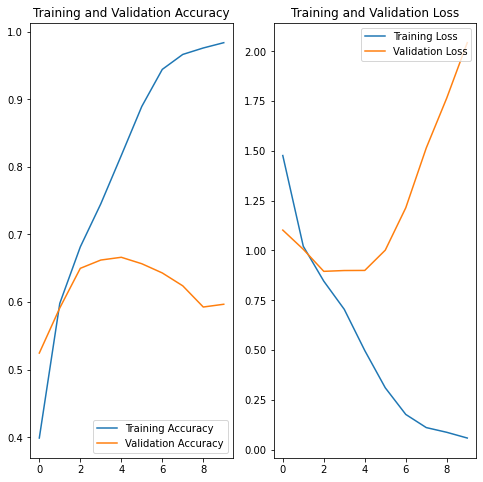

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 60% accuracy on the validation set.

Let's look at what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *Dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting then using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

We will implement data augmentation using experimental [Keras Preprocessing Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/?version=nightly). These can be included inside your model like other layers, and run on the GPU.

In [24]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

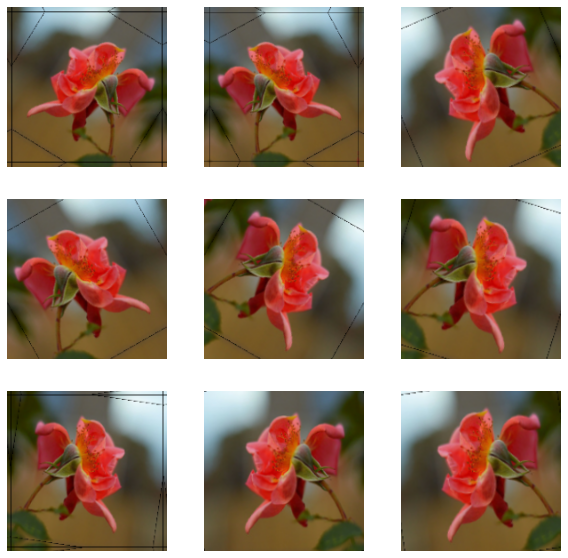

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

We will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce [Dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) to the network, a form of *regularization*.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using `layers.Dropout`, then train it using augmented images.

In [26]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [29]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


 1/92 [..............................] - ETA: 58s - loss: 1.6260 - accuracy: 0.2500

 6/92 [>.............................] - ETA: 10s - loss: 1.7910 - accuracy: 0.2196

11/92 [==>...........................] - ETA: 5s - loss: 1.7554 - accuracy: 0.2212 

16/92 [====>.........................] - ETA: 3s - loss: 1.7225 - accuracy: 0.2232

21/92 [=====>........................] - ETA: 2s - loss: 1.6963 - accuracy: 0.2331

26/92 [=======>......................] - ETA: 2s - loss: 1.6718 - accuracy: 0.2419

31/92 [=========>....................] - ETA: 1s - loss: 1.6484 - accuracy: 0.2504

36/92 [==========>...................] - ETA: 1s - loss: 1.6278 - accuracy: 0.2587

41/92 [============>.................] - ETA: 1s - loss: 1.6097 - accuracy: 0.2664

46/92 [==============>...............] - ETA: 1s - loss: 1.5935 - accuracy: 0.2736

51/92 [===============>..............] - ETA: 0s - loss: 1.5783 - accuracy: 0.2807

56/92 [=================>............] - ETA: 0s - loss: 1.5639 - accuracy: 0.2874

61/92 [==================>...........] - ETA: 0s - loss: 1.5509 - accuracy: 0.2937

66/92 [====================>.........] - ETA: 0s - loss: 1.5389 - accuracy: 0.2997

71/92 [======================>.......] - ETA: 0s - loss: 1.5276 - accuracy: 0.3055

76/92 [=======================>......] - ETA: 0s - loss: 1.5168 - accuracy: 0.3111

81/92 [=========================>....] - ETA: 0s - loss: 1.5065 - accuracy: 0.3163

86/92 [===========================>..] - ETA: 0s - loss: 1.4969 - accuracy: 0.3213

91/92 [============================>.] - ETA: 0s - loss: 1.4877 - accuracy: 0.3260

92/92 [==============================] - 2s 20ms/step - loss: 1.4842 - accuracy: 0.3279 - val_loss: 1.0863 - val_accuracy: 0.5640


Epoch 2/15
 1/92 [..............................] - ETA: 0s - loss: 1.3549 - accuracy: 0.4375

 6/92 [>.............................] - ETA: 0s - loss: 1.2265 - accuracy: 0.4879

11/92 [==>...........................] - ETA: 0s - loss: 1.1899 - accuracy: 0.5076

16/92 [====>.........................] - ETA: 0s - loss: 1.1698 - accuracy: 0.5150

21/92 [=====>........................] - ETA: 0s - loss: 1.1600 - accuracy: 0.5146

26/92 [=======>......................] - ETA: 0s - loss: 1.1510 - accuracy: 0.5164

31/92 [=========>....................] - ETA: 0s - loss: 1.1460 - accuracy: 0.5167

36/92 [==========>...................] - ETA: 0s - loss: 1.1426 - accuracy: 0.5167

41/92 [============>.................] - ETA: 0s - loss: 1.1410 - accuracy: 0.5160

46/92 [==============>...............] - ETA: 0s - loss: 1.1394 - accuracy: 0.5162

51/92 [===============>..............] - ETA: 0s - loss: 1.1378 - accuracy: 0.5170

56/92 [=================>............] - ETA: 0s - loss: 1.1367 - accuracy: 0.5179

61/92 [==================>...........] - ETA: 0s - loss: 1.1351 - accuracy: 0.5190

66/92 [====================>.........] - ETA: 0s - loss: 1.1332 - accuracy: 0.5203

71/92 [======================>.......] - ETA: 0s - loss: 1.1311 - accuracy: 0.5216

76/92 [=======================>......] - ETA: 0s - loss: 1.1292 - accuracy: 0.5230

81/92 [=========================>....] - ETA: 0s - loss: 1.1272 - accuracy: 0.5246

86/92 [===========================>..] - ETA: 0s - loss: 1.1248 - accuracy: 0.5263

91/92 [============================>.] - ETA: 0s - loss: 1.1224 - accuracy: 0.5279

92/92 [==============================] - 1s 12ms/step - loss: 1.1215 - accuracy: 0.5284 - val_loss: 1.0374 - val_accuracy: 0.6022


Epoch 3/15
 1/92 [..............................] - ETA: 1s - loss: 0.9585 - accuracy: 0.5938

 6/92 [>.............................] - ETA: 0s - loss: 0.9430 - accuracy: 0.6027

11/92 [==>...........................] - ETA: 0s - loss: 0.9583 - accuracy: 0.5991

16/92 [====>.........................] - ETA: 0s - loss: 0.9703 - accuracy: 0.5964

21/92 [=====>........................] - ETA: 0s - loss: 0.9760 - accuracy: 0.5966

26/92 [=======>......................] - ETA: 0s - loss: 0.9782 - accuracy: 0.5961

31/92 [=========>....................] - ETA: 0s - loss: 0.9797 - accuracy: 0.5960

36/92 [==========>...................] - ETA: 0s - loss: 0.9787 - accuracy: 0.5972

41/92 [============>.................] - ETA: 0s - loss: 0.9771 - accuracy: 0.5986

46/92 [==============>...............] - ETA: 0s - loss: 0.9759 - accuracy: 0.5999

51/92 [===============>..............] - ETA: 0s - loss: 0.9752 - accuracy: 0.6010

56/92 [=================>............] - ETA: 0s - loss: 0.9745 - accuracy: 0.6020

61/92 [==================>...........] - ETA: 0s - loss: 0.9733 - accuracy: 0.6034

66/92 [====================>.........] - ETA: 0s - loss: 0.9724 - accuracy: 0.6048

71/92 [======================>.......] - ETA: 0s - loss: 0.9715 - accuracy: 0.6063

76/92 [=======================>......] - ETA: 0s - loss: 0.9703 - accuracy: 0.6077

81/92 [=========================>....] - ETA: 0s - loss: 0.9694 - accuracy: 0.6090

86/92 [===========================>..] - ETA: 0s - loss: 0.9688 - accuracy: 0.6101

91/92 [============================>.] - ETA: 0s - loss: 0.9683 - accuracy: 0.6112

92/92 [==============================] - 1s 12ms/step - loss: 0.9680 - accuracy: 0.6117 - val_loss: 0.9200 - val_accuracy: 0.6485


Epoch 4/15
 1/92 [..............................] - ETA: 1s - loss: 0.8718 - accuracy: 0.6875

 6/92 [>.............................] - ETA: 0s - loss: 0.8991 - accuracy: 0.6764

11/92 [==>...........................] - ETA: 0s - loss: 0.8772 - accuracy: 0.6857

16/92 [====>.........................] - ETA: 0s - loss: 0.8677 - accuracy: 0.6849

21/92 [=====>........................] - ETA: 0s - loss: 0.8644 - accuracy: 0.6834

26/92 [=======>......................] - ETA: 0s - loss: 0.8630 - accuracy: 0.6826

31/92 [=========>....................] - ETA: 0s - loss: 0.8614 - accuracy: 0.6815

36/92 [==========>...................] - ETA: 0s - loss: 0.8594 - accuracy: 0.6809

41/92 [============>.................] - ETA: 0s - loss: 0.8588 - accuracy: 0.6796

46/92 [==============>...............] - ETA: 0s - loss: 0.8574 - accuracy: 0.6789

51/92 [===============>..............] - ETA: 0s - loss: 0.8556 - accuracy: 0.6787

56/92 [=================>............] - ETA: 0s - loss: 0.8538 - accuracy: 0.6787

61/92 [==================>...........] - ETA: 0s - loss: 0.8532 - accuracy: 0.6784

66/92 [====================>.........] - ETA: 0s - loss: 0.8531 - accuracy: 0.6779

71/92 [======================>.......] - ETA: 0s - loss: 0.8532 - accuracy: 0.6773

76/92 [=======================>......] - ETA: 0s - loss: 0.8533 - accuracy: 0.6767

81/92 [=========================>....] - ETA: 0s - loss: 0.8536 - accuracy: 0.6759

86/92 [===========================>..] - ETA: 0s - loss: 0.8538 - accuracy: 0.6755

91/92 [============================>.] - ETA: 0s - loss: 0.8538 - accuracy: 0.6753

92/92 [==============================] - 1s 12ms/step - loss: 0.8538 - accuracy: 0.6753 - val_loss: 0.9206 - val_accuracy: 0.6417


Epoch 5/15
 1/92 [..............................] - ETA: 1s - loss: 0.6351 - accuracy: 0.7188

 6/92 [>.............................] - ETA: 0s - loss: 0.7741 - accuracy: 0.6829

11/92 [==>...........................] - ETA: 0s - loss: 0.7730 - accuracy: 0.6874

16/92 [====>.........................] - ETA: 0s - loss: 0.7679 - accuracy: 0.6914

21/92 [=====>........................] - ETA: 0s - loss: 0.7687 - accuracy: 0.6937

26/92 [=======>......................] - ETA: 0s - loss: 0.7673 - accuracy: 0.6962

31/92 [=========>....................] - ETA: 0s - loss: 0.7667 - accuracy: 0.6970

36/92 [==========>...................] - ETA: 0s - loss: 0.7665 - accuracy: 0.6974

41/92 [============>.................] - ETA: 0s - loss: 0.7674 - accuracy: 0.6975

46/92 [==============>...............] - ETA: 0s - loss: 0.7686 - accuracy: 0.6976

51/92 [===============>..............] - ETA: 0s - loss: 0.7698 - accuracy: 0.6977

56/92 [=================>............] - ETA: 0s - loss: 0.7704 - accuracy: 0.6977

61/92 [==================>...........] - ETA: 0s - loss: 0.7709 - accuracy: 0.6978

66/92 [====================>.........] - ETA: 0s - loss: 0.7712 - accuracy: 0.6981

71/92 [======================>.......] - ETA: 0s - loss: 0.7715 - accuracy: 0.6983

76/92 [=======================>......] - ETA: 0s - loss: 0.7720 - accuracy: 0.6982

81/92 [=========================>....] - ETA: 0s - loss: 0.7725 - accuracy: 0.6981

86/92 [===========================>..] - ETA: 0s - loss: 0.7732 - accuracy: 0.6981

91/92 [============================>.] - ETA: 0s - loss: 0.7740 - accuracy: 0.6978

92/92 [==============================] - 1s 12ms/step - loss: 0.7744 - accuracy: 0.6977 - val_loss: 0.8169 - val_accuracy: 0.6839


Epoch 6/15
 1/92 [..............................] - ETA: 0s - loss: 0.8518 - accuracy: 0.7500

 6/92 [>.............................] - ETA: 0s - loss: 0.7671 - accuracy: 0.7305

11/92 [==>...........................] - ETA: 0s - loss: 0.7606 - accuracy: 0.7219

16/92 [====>.........................] - ETA: 0s - loss: 0.7735 - accuracy: 0.7171

21/92 [=====>........................] - ETA: 0s - loss: 0.7809 - accuracy: 0.7124

26/92 [=======>......................] - ETA: 0s - loss: 0.7832 - accuracy: 0.7099

31/92 [=========>....................] - ETA: 0s - loss: 0.7842 - accuracy: 0.7087

36/92 [==========>...................] - ETA: 0s - loss: 0.7849 - accuracy: 0.7073

41/92 [============>.................] - ETA: 0s - loss: 0.7856 - accuracy: 0.7063

46/92 [==============>...............] - ETA: 0s - loss: 0.7857 - accuracy: 0.7056

51/92 [===============>..............] - ETA: 0s - loss: 0.7859 - accuracy: 0.7053

56/92 [=================>............] - ETA: 0s - loss: 0.7859 - accuracy: 0.7052

61/92 [==================>...........] - ETA: 0s - loss: 0.7852 - accuracy: 0.7055

66/92 [====================>.........] - ETA: 0s - loss: 0.7840 - accuracy: 0.7059

71/92 [======================>.......] - ETA: 0s - loss: 0.7823 - accuracy: 0.7065

76/92 [=======================>......] - ETA: 0s - loss: 0.7809 - accuracy: 0.7071

81/92 [=========================>....] - ETA: 0s - loss: 0.7793 - accuracy: 0.7078

86/92 [===========================>..] - ETA: 0s - loss: 0.7778 - accuracy: 0.7085

91/92 [============================>.] - ETA: 0s - loss: 0.7763 - accuracy: 0.7091

92/92 [==============================] - 1s 13ms/step - loss: 0.7758 - accuracy: 0.7093 - val_loss: 0.7743 - val_accuracy: 0.6880


Epoch 7/15
 1/92 [..............................] - ETA: 1s - loss: 0.6745 - accuracy: 0.7500

 6/92 [>.............................] - ETA: 0s - loss: 0.6597 - accuracy: 0.7772

11/92 [==>...........................] - ETA: 0s - loss: 0.6626 - accuracy: 0.7704

16/92 [====>.........................] - ETA: 0s - loss: 0.6544 - accuracy: 0.7698

21/92 [=====>........................] - ETA: 0s - loss: 0.6511 - accuracy: 0.7689

26/92 [=======>......................] - ETA: 0s - loss: 0.6499 - accuracy: 0.7673

31/92 [=========>....................] - ETA: 0s - loss: 0.6501 - accuracy: 0.7656

36/92 [==========>...................] - ETA: 0s - loss: 0.6513 - accuracy: 0.7640

41/92 [============>.................] - ETA: 0s - loss: 0.6534 - accuracy: 0.7629

46/92 [==============>...............] - ETA: 0s - loss: 0.6561 - accuracy: 0.7616

51/92 [===============>..............] - ETA: 0s - loss: 0.6592 - accuracy: 0.7600

56/92 [=================>............] - ETA: 0s - loss: 0.6626 - accuracy: 0.7583

61/92 [==================>...........] - ETA: 0s - loss: 0.6656 - accuracy: 0.7568

66/92 [====================>.........] - ETA: 0s - loss: 0.6688 - accuracy: 0.7550

71/92 [======================>.......] - ETA: 0s - loss: 0.6711 - accuracy: 0.7537

76/92 [=======================>......] - ETA: 0s - loss: 0.6732 - accuracy: 0.7525

81/92 [=========================>....] - ETA: 0s - loss: 0.6753 - accuracy: 0.7512

86/92 [===========================>..] - ETA: 0s - loss: 0.6775 - accuracy: 0.7499

91/92 [============================>.] - ETA: 0s - loss: 0.6797 - accuracy: 0.7486

92/92 [==============================] - 1s 13ms/step - loss: 0.6805 - accuracy: 0.7481 - val_loss: 0.8598 - val_accuracy: 0.6540


Epoch 8/15
 1/92 [..............................] - ETA: 1s - loss: 0.5735 - accuracy: 0.7500

 6/92 [>.............................] - ETA: 0s - loss: 0.6807 - accuracy: 0.7356

11/92 [==>...........................] - ETA: 0s - loss: 0.7124 - accuracy: 0.7297

16/92 [====>.........................] - ETA: 0s - loss: 0.7233 - accuracy: 0.7264

21/92 [=====>........................] - ETA: 0s - loss: 0.7258 - accuracy: 0.7249

26/92 [=======>......................] - ETA: 0s - loss: 0.7256 - accuracy: 0.7241

31/92 [=========>....................] - ETA: 0s - loss: 0.7236 - accuracy: 0.7247

36/92 [==========>...................] - ETA: 0s - loss: 0.7233 - accuracy: 0.7247

41/92 [============>.................] - ETA: 0s - loss: 0.7231 - accuracy: 0.7249

46/92 [==============>...............] - ETA: 0s - loss: 0.7220 - accuracy: 0.7255

51/92 [===============>..............] - ETA: 0s - loss: 0.7210 - accuracy: 0.7260

56/92 [=================>............] - ETA: 0s - loss: 0.7202 - accuracy: 0.7262

61/92 [==================>...........] - ETA: 0s - loss: 0.7196 - accuracy: 0.7262

66/92 [====================>.........] - ETA: 0s - loss: 0.7190 - accuracy: 0.7260

71/92 [======================>.......] - ETA: 0s - loss: 0.7180 - accuracy: 0.7262

76/92 [=======================>......] - ETA: 0s - loss: 0.7170 - accuracy: 0.7263

81/92 [=========================>....] - ETA: 0s - loss: 0.7162 - accuracy: 0.7266

86/92 [===========================>..] - ETA: 0s - loss: 0.7151 - accuracy: 0.7270

91/92 [============================>.] - ETA: 0s - loss: 0.7137 - accuracy: 0.7276

92/92 [==============================] - 1s 13ms/step - loss: 0.7132 - accuracy: 0.7278 - val_loss: 0.7177 - val_accuracy: 0.7207


Epoch 9/15
 1/92 [..............................] - ETA: 1s - loss: 0.7867 - accuracy: 0.7812

 6/92 [>.............................] - ETA: 0s - loss: 0.7222 - accuracy: 0.7798

11/92 [==>...........................] - ETA: 0s - loss: 0.7182 - accuracy: 0.7670

16/92 [====>.........................] - ETA: 0s - loss: 0.7140 - accuracy: 0.7595

21/92 [=====>........................] - ETA: 0s - loss: 0.7053 - accuracy: 0.7576

26/92 [=======>......................] - ETA: 0s - loss: 0.7007 - accuracy: 0.7561

31/92 [=========>....................] - ETA: 0s - loss: 0.6956 - accuracy: 0.7553

36/92 [==========>...................] - ETA: 0s - loss: 0.6906 - accuracy: 0.7547

41/92 [============>.................] - ETA: 0s - loss: 0.6863 - accuracy: 0.7548

46/92 [==============>...............] - ETA: 0s - loss: 0.6814 - accuracy: 0.7554

51/92 [===============>..............] - ETA: 0s - loss: 0.6773 - accuracy: 0.7558

56/92 [=================>............] - ETA: 0s - loss: 0.6735 - accuracy: 0.7567

61/92 [==================>...........] - ETA: 0s - loss: 0.6706 - accuracy: 0.7574

66/92 [====================>.........] - ETA: 0s - loss: 0.6684 - accuracy: 0.7579

71/92 [======================>.......] - ETA: 0s - loss: 0.6666 - accuracy: 0.7583

76/92 [=======================>......] - ETA: 0s - loss: 0.6654 - accuracy: 0.7585

81/92 [=========================>....] - ETA: 0s - loss: 0.6646 - accuracy: 0.7584

86/92 [===========================>..] - ETA: 0s - loss: 0.6641 - accuracy: 0.7583

91/92 [============================>.] - ETA: 0s - loss: 0.6636 - accuracy: 0.7581

92/92 [==============================] - 1s 13ms/step - loss: 0.6634 - accuracy: 0.7580 - val_loss: 0.7152 - val_accuracy: 0.7166


Epoch 10/15
 1/92 [..............................] - ETA: 1s - loss: 1.0050 - accuracy: 0.6250

 6/92 [>.............................] - ETA: 0s - loss: 0.7651 - accuracy: 0.7135

11/92 [==>...........................] - ETA: 0s - loss: 0.7190 - accuracy: 0.7363

16/92 [====>.........................] - ETA: 0s - loss: 0.6970 - accuracy: 0.7446

21/92 [=====>........................] - ETA: 0s - loss: 0.6833 - accuracy: 0.7496

26/92 [=======>......................] - ETA: 0s - loss: 0.6771 - accuracy: 0.7514

31/92 [=========>....................] - ETA: 0s - loss: 0.6745 - accuracy: 0.7507

36/92 [==========>...................] - ETA: 0s - loss: 0.6734 - accuracy: 0.7504

41/92 [============>.................] - ETA: 0s - loss: 0.6721 - accuracy: 0.7507

46/92 [==============>...............] - ETA: 0s - loss: 0.6705 - accuracy: 0.7509

51/92 [===============>..............] - ETA: 0s - loss: 0.6688 - accuracy: 0.7510

56/92 [=================>............] - ETA: 0s - loss: 0.6678 - accuracy: 0.7508

61/92 [==================>...........] - ETA: 0s - loss: 0.6668 - accuracy: 0.7506

66/92 [====================>.........] - ETA: 0s - loss: 0.6657 - accuracy: 0.7507

71/92 [======================>.......] - ETA: 0s - loss: 0.6642 - accuracy: 0.7510

76/92 [=======================>......] - ETA: 0s - loss: 0.6625 - accuracy: 0.7515

81/92 [=========================>....] - ETA: 0s - loss: 0.6606 - accuracy: 0.7522

86/92 [===========================>..] - ETA: 0s - loss: 0.6587 - accuracy: 0.7529

91/92 [============================>.] - ETA: 0s - loss: 0.6568 - accuracy: 0.7536

92/92 [==============================] - 1s 13ms/step - loss: 0.6562 - accuracy: 0.7538 - val_loss: 0.7251 - val_accuracy: 0.7248


Epoch 11/15
 1/92 [..............................] - ETA: 1s - loss: 0.4759 - accuracy: 0.8438

 6/92 [>.............................] - ETA: 0s - loss: 0.4828 - accuracy: 0.8420

11/92 [==>...........................] - ETA: 0s - loss: 0.5119 - accuracy: 0.8204

16/92 [====>.........................] - ETA: 0s - loss: 0.5309 - accuracy: 0.8103

21/92 [=====>........................] - ETA: 0s - loss: 0.5437 - accuracy: 0.8031

26/92 [=======>......................] - ETA: 0s - loss: 0.5489 - accuracy: 0.8005

31/92 [=========>....................] - ETA: 0s - loss: 0.5523 - accuracy: 0.7985

36/92 [==========>...................] - ETA: 0s - loss: 0.5558 - accuracy: 0.7964

41/92 [============>.................] - ETA: 0s - loss: 0.5608 - accuracy: 0.7935

46/92 [==============>...............] - ETA: 0s - loss: 0.5644 - accuracy: 0.7914

51/92 [===============>..............] - ETA: 0s - loss: 0.5669 - accuracy: 0.7901

56/92 [=================>............] - ETA: 0s - loss: 0.5691 - accuracy: 0.7890

61/92 [==================>...........] - ETA: 0s - loss: 0.5710 - accuracy: 0.7881

66/92 [====================>.........] - ETA: 0s - loss: 0.5731 - accuracy: 0.7872

71/92 [======================>.......] - ETA: 0s - loss: 0.5748 - accuracy: 0.7865

76/92 [=======================>......] - ETA: 0s - loss: 0.5761 - accuracy: 0.7860

81/92 [=========================>....] - ETA: 0s - loss: 0.5775 - accuracy: 0.7853

86/92 [===========================>..] - ETA: 0s - loss: 0.5786 - accuracy: 0.7847

91/92 [============================>.] - ETA: 0s - loss: 0.5795 - accuracy: 0.7842

92/92 [==============================] - 1s 13ms/step - loss: 0.5798 - accuracy: 0.7840 - val_loss: 0.7016 - val_accuracy: 0.7357


Epoch 12/15
 1/92 [..............................] - ETA: 1s - loss: 0.5670 - accuracy: 0.8125

 6/92 [>.............................] - ETA: 0s - loss: 0.5016 - accuracy: 0.8219

11/92 [==>...........................] - ETA: 0s - loss: 0.5078 - accuracy: 0.8154

16/92 [====>.........................] - ETA: 0s - loss: 0.5233 - accuracy: 0.8105

21/92 [=====>........................] - ETA: 0s - loss: 0.5323 - accuracy: 0.8083

26/92 [=======>......................] - ETA: 0s - loss: 0.5391 - accuracy: 0.8054

31/92 [=========>....................] - ETA: 0s - loss: 0.5446 - accuracy: 0.8026

36/92 [==========>...................] - ETA: 0s - loss: 0.5480 - accuracy: 0.8006

41/92 [============>.................] - ETA: 0s - loss: 0.5514 - accuracy: 0.7986

46/92 [==============>...............] - ETA: 0s - loss: 0.5540 - accuracy: 0.7971

51/92 [===============>..............] - ETA: 0s - loss: 0.5563 - accuracy: 0.7959

56/92 [=================>............] - ETA: 0s - loss: 0.5578 - accuracy: 0.7951

61/92 [==================>...........] - ETA: 0s - loss: 0.5589 - accuracy: 0.7944

66/92 [====================>.........] - ETA: 0s - loss: 0.5598 - accuracy: 0.7938

71/92 [======================>.......] - ETA: 0s - loss: 0.5609 - accuracy: 0.7932

76/92 [=======================>......] - ETA: 0s - loss: 0.5618 - accuracy: 0.7926

81/92 [=========================>....] - ETA: 0s - loss: 0.5624 - accuracy: 0.7921

86/92 [===========================>..] - ETA: 0s - loss: 0.5629 - accuracy: 0.7917

91/92 [============================>.] - ETA: 0s - loss: 0.5633 - accuracy: 0.7914

92/92 [==============================] - 1s 13ms/step - loss: 0.5635 - accuracy: 0.7913 - val_loss: 0.7755 - val_accuracy: 0.7248


Epoch 13/15
 1/92 [..............................] - ETA: 1s - loss: 0.4645 - accuracy: 0.8125

 6/92 [>.............................] - ETA: 0s - loss: 0.5790 - accuracy: 0.7681

11/92 [==>...........................] - ETA: 0s - loss: 0.5767 - accuracy: 0.7757

16/92 [====>.........................] - ETA: 0s - loss: 0.5698 - accuracy: 0.7814

21/92 [=====>........................] - ETA: 0s - loss: 0.5618 - accuracy: 0.7860

26/92 [=======>......................] - ETA: 0s - loss: 0.5550 - accuracy: 0.7899

31/92 [=========>....................] - ETA: 0s - loss: 0.5506 - accuracy: 0.7926

36/92 [==========>...................] - ETA: 0s - loss: 0.5474 - accuracy: 0.7943

41/92 [============>.................] - ETA: 0s - loss: 0.5452 - accuracy: 0.7952

46/92 [==============>...............] - ETA: 0s - loss: 0.5429 - accuracy: 0.7960

51/92 [===============>..............] - ETA: 0s - loss: 0.5408 - accuracy: 0.7968

56/92 [=================>............] - ETA: 0s - loss: 0.5388 - accuracy: 0.7975

61/92 [==================>...........] - ETA: 0s - loss: 0.5374 - accuracy: 0.7979

66/92 [====================>.........] - ETA: 0s - loss: 0.5366 - accuracy: 0.7981

71/92 [======================>.......] - ETA: 0s - loss: 0.5359 - accuracy: 0.7983

76/92 [=======================>......] - ETA: 0s - loss: 0.5355 - accuracy: 0.7985

81/92 [=========================>....] - ETA: 0s - loss: 0.5353 - accuracy: 0.7985

86/92 [===========================>..] - ETA: 0s - loss: 0.5355 - accuracy: 0.7985

91/92 [============================>.] - ETA: 0s - loss: 0.5360 - accuracy: 0.7982

92/92 [==============================] - 1s 13ms/step - loss: 0.5361 - accuracy: 0.7982 - val_loss: 0.7575 - val_accuracy: 0.7153


Epoch 14/15
 1/92 [..............................] - ETA: 1s - loss: 0.4378 - accuracy: 0.8125

 6/92 [>.............................] - ETA: 0s - loss: 0.4707 - accuracy: 0.8270

11/92 [==>...........................] - ETA: 0s - loss: 0.5042 - accuracy: 0.8143

16/92 [====>.........................] - ETA: 0s - loss: 0.5194 - accuracy: 0.8104

21/92 [=====>........................] - ETA: 0s - loss: 0.5251 - accuracy: 0.8095

26/92 [=======>......................] - ETA: 0s - loss: 0.5255 - accuracy: 0.8096

31/92 [=========>....................] - ETA: 0s - loss: 0.5249 - accuracy: 0.8099

36/92 [==========>...................] - ETA: 0s - loss: 0.5247 - accuracy: 0.8100

41/92 [============>.................] - ETA: 0s - loss: 0.5253 - accuracy: 0.8097

46/92 [==============>...............] - ETA: 0s - loss: 0.5267 - accuracy: 0.8091

51/92 [===============>..............] - ETA: 0s - loss: 0.5279 - accuracy: 0.8089

56/92 [=================>............] - ETA: 0s - loss: 0.5294 - accuracy: 0.8084

61/92 [==================>...........] - ETA: 0s - loss: 0.5317 - accuracy: 0.8076

66/92 [====================>.........] - ETA: 0s - loss: 0.5338 - accuracy: 0.8067

71/92 [======================>.......] - ETA: 0s - loss: 0.5358 - accuracy: 0.8057

76/92 [=======================>......] - ETA: 0s - loss: 0.5376 - accuracy: 0.8047

81/92 [=========================>....] - ETA: 0s - loss: 0.5390 - accuracy: 0.8039

86/92 [===========================>..] - ETA: 0s - loss: 0.5404 - accuracy: 0.8031

91/92 [============================>.] - ETA: 0s - loss: 0.5416 - accuracy: 0.8024

92/92 [==============================] - 1s 13ms/step - loss: 0.5420 - accuracy: 0.8022 - val_loss: 0.7375 - val_accuracy: 0.7302


Epoch 15/15
 1/92 [..............................] - ETA: 0s - loss: 0.3699 - accuracy: 0.8438

 6/92 [>.............................] - ETA: 0s - loss: 0.4530 - accuracy: 0.8322

11/92 [==>...........................] - ETA: 0s - loss: 0.4789 - accuracy: 0.8339

16/92 [====>.........................] - ETA: 0s - loss: 0.4979 - accuracy: 0.8292

21/92 [=====>........................] - ETA: 0s - loss: 0.5036 - accuracy: 0.8275

26/92 [=======>......................] - ETA: 0s - loss: 0.5121 - accuracy: 0.8240

31/92 [=========>....................] - ETA: 0s - loss: 0.5166 - accuracy: 0.8214

36/92 [==========>...................] - ETA: 0s - loss: 0.5191 - accuracy: 0.8190

41/92 [============>.................] - ETA: 0s - loss: 0.5209 - accuracy: 0.8174

46/92 [==============>...............] - ETA: 0s - loss: 0.5222 - accuracy: 0.8158

51/92 [===============>..............] - ETA: 0s - loss: 0.5221 - accuracy: 0.8148

56/92 [=================>............] - ETA: 0s - loss: 0.5208 - accuracy: 0.8145

61/92 [==================>...........] - ETA: 0s - loss: 0.5193 - accuracy: 0.8142

66/92 [====================>.........] - ETA: 0s - loss: 0.5180 - accuracy: 0.8138

71/92 [======================>.......] - ETA: 0s - loss: 0.5169 - accuracy: 0.8135

76/92 [=======================>......] - ETA: 0s - loss: 0.5159 - accuracy: 0.8132

81/92 [=========================>....] - ETA: 0s - loss: 0.5149 - accuracy: 0.8129

86/92 [===========================>..] - ETA: 0s - loss: 0.5140 - accuracy: 0.8127

91/92 [============================>.] - ETA: 0s - loss: 0.5134 - accuracy: 0.8122

92/92 [==============================] - 1s 12ms/step - loss: 0.5132 - accuracy: 0.8120 - val_loss: 0.7561 - val_accuracy: 0.7289


## Visualize training results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

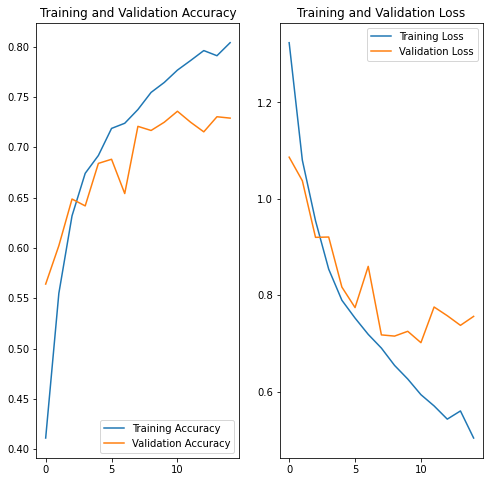

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.

In [31]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

  8192/117948 [=>............................] - ETA: 0s

122880/117948 [===============================] - 0s 0us/step


This image most likely belongs to sunflowers with a 89.39 percent confidence.
